# Image Segmentation using Watershed Algorithm

## Project Overview

This project implements the **Watershed Algorithm**, a powerful morphology-based technique for separating touching or overlapping objects in an image. The algorithm treats pixel intensities as a topographic surface and finds watershed lines that divide different regions, making it particularly effective for segmenting objects that are close together or in contact.

---

## What is the Watershed Algorithm?

The **Watershed Algorithm** is inspired by geographical watersheds:

### Topographic Analogy:
Imagine the grayscale image as a topographic relief (landscape):
- **Pixel intensity** = Altitude/Elevation
- **Dark regions** (low intensity) = Valleys
- **Bright regions** (high intensity) = Mountains
- **Gradient** = Slopes

### The Flooding Process:
1. Water is poured into each valley (local minimum)
2. Water rises and fills the basins
3. When water from different basins meets, a "dam" (watershed line) is built
4. These watershed lines become the segmentation boundaries

---

## Why Watershed for Object Separation?

### The Problem:
- **Touching objects** appear connected in the image
- **Overlapping objects** are difficult to separate
- **Traditional thresholding** treats connected objects as one

### The Solution:
- Watershed identifies **natural boundaries** between objects
- Creates **separation lines** even for touching objects
- Works well when objects have **similar intensities**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


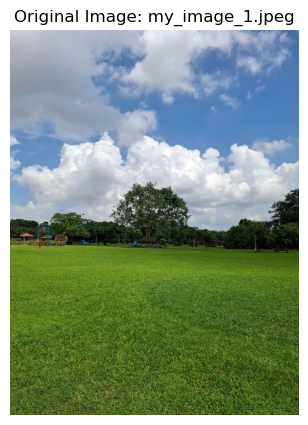

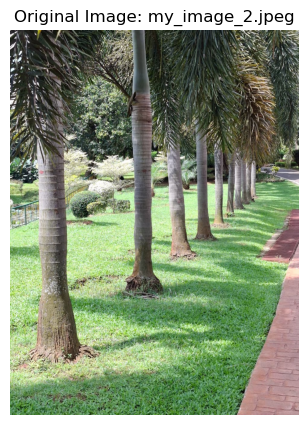

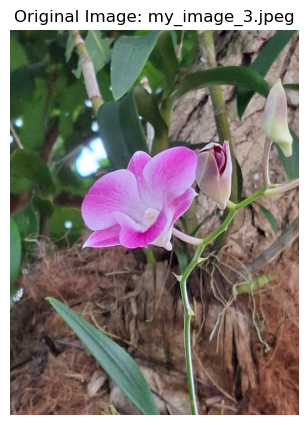

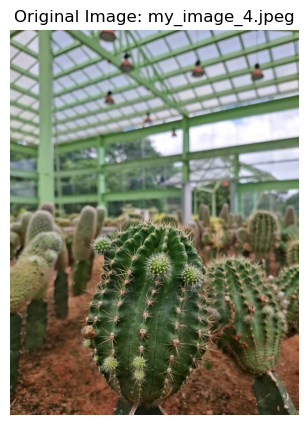

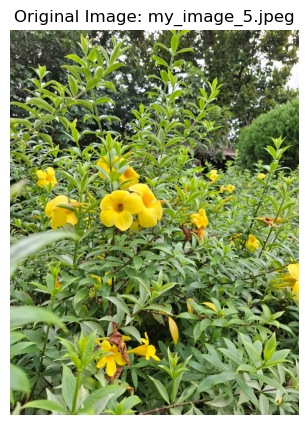

In [4]:
image_folder = "Images"

# List all images
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Display original images
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {img_file}")
    plt.axis('off')
    plt.show()


## Algorithm Pipeline

Our implementation follows these key steps:

### 1. **Grayscale Conversion**
```python
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
```
- Converts RGB to single-channel intensity image
- Simplifies processing while retaining structure

### 2. **Otsu's Thresholding**
```python
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
```

**What is Otsu's Method?**
- **Automatic threshold selection**: No manual threshold needed
- **Optimal threshold**: Minimizes intra-class variance
- **THRESH_BINARY_INV**: Inverts result (objects white, background black)
- **Purpose**: Creates binary mask separating foreground from background

**Why Invert?**
- Most images have dark objects on light background
- Inversion makes objects white (foreground) for easier processing

### 3. **Morphological Opening (Noise Removal)**
```python
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
```

**What is Morphological Opening?**
- **Opening** = Erosion followed by Dilation
- **Erosion**: Shrinks objects, removes small noise
- **Dilation**: Expands objects back to original size

**Effect:**
- Removes salt-and-pepper noise
- Smooths object boundaries
- Eliminates small spurious regions
- Preserves object size and shape

### 4. **Sure Background Area**
```python
sure_bg = cv2.dilate(opening, kernel, iterations=3)
```

**Purpose:**
- Expands objects to include surrounding pixels
- Everything outside dilated regions is **definitely background**
- Creates a confident background mask

### 5. **Distance Transform**
```python
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
```

**What is Distance Transform?**
- Calculates distance of each foreground pixel to nearest background pixel
- **High values**: Center of objects (far from edges)
- **Low values**: Near object boundaries

**Visual Representation:**
- Peaks at object centers
- Valleys at object boundaries
- Creates a topographic map of the objects

**Distance Type: DIST_L2**
- L2 = Euclidean distance
- Most accurate distance metric
- Formula: √[(x₁-x₂)² + (y₁-y₂)²]

### 6. **Sure Foreground Area**
```python
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
```

**Strategy:**
- Take pixels with distance > 70% of maximum distance
- These are **definitely object centers** (far from boundaries)
- Creates seeds for watershed algorithm

**Why 0.7 (70%)?**
- Conservative estimate ensuring we're inside objects
- Avoids including boundary pixels
- Can be adjusted: Higher = more conservative, Lower = more aggressive

### 7. **Unknown Region**
```python
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
```

**Three Regions Created:**
1. **Sure Background**: Definitely not object (black in sure_bg)
2. **Sure Foreground**: Definitely object centers (white in sure_fg)
3. **Unknown Region**: Boundaries and uncertain areas

**The unknown region is where watershed will find boundaries!**

### 8. **Marker Labeling**
```python
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0
```

**Connected Components:**
- Assigns unique label to each separate object
- Labels: 0 (background), 1, 2, 3... (objects)

**Marker Adjustment:**
- Add 1 to all labels (background becomes 1, objects become 2, 3, 4...)
- Set unknown region to 0
- **Why?** Watershed treats 0 as unknown, >0 as known regions


### 9. **Boundary Visualization**
```python
img_rgb[markers_ws == -1] = [255,0,0]  # Red boundaries
```
- Watershed lines (value -1) are colored red
- Creates clear visual separation between objects

---

## Understanding the Results

### What the Algorithm Produces:

1. **Segmented Regions**: Each object has a unique marker value
2. **Boundary Lines**: Red lines (-1 markers) separate objects
3. **Object Separation**: Touching objects are clearly separated

### Key Observations:

**Successful Segmentation Indicators:**
- Clear red boundaries between objects
- Each distinct object has different marker value
- Boundaries follow natural object edges
- Minimal over-segmentation (too many regions)
- Minimal under-segmentation (merged objects)

**Common Issues:**
- **Over-segmentation**: Too many regions (tune threshold in step 6)
- **Under-segmentation**: Objects not separated (adjust morphological operations)
- **Irregular boundaries**: Noisy input image (increase opening iterations)


In [5]:
def watershed_segmentation(image_path):
    # Step 1: Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply threshold to get binary image
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 4: Noise removal using morphological opening
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 5: Sure background area (dilate)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Step 6: Sure foreground area (distance transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Step 7: Unknown region (subtract foreground from background)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 8: Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0

    # Step 9: Apply watershed
    markers_ws = cv2.watershed(img, markers)

    # Step 10: Mark boundaries in red
    img_rgb[markers_ws == -1] = [255,0,0]  # Red boundaries

    return img_rgb, markers_ws


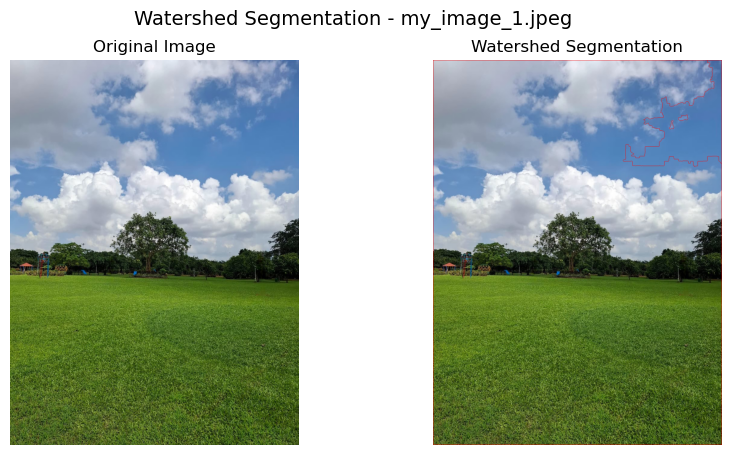

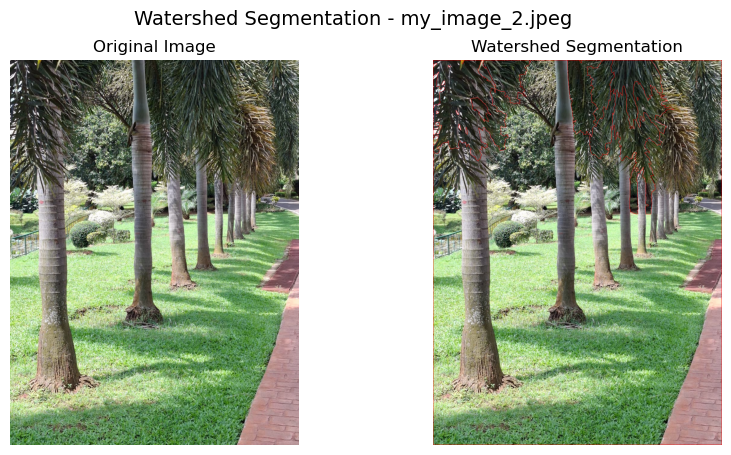

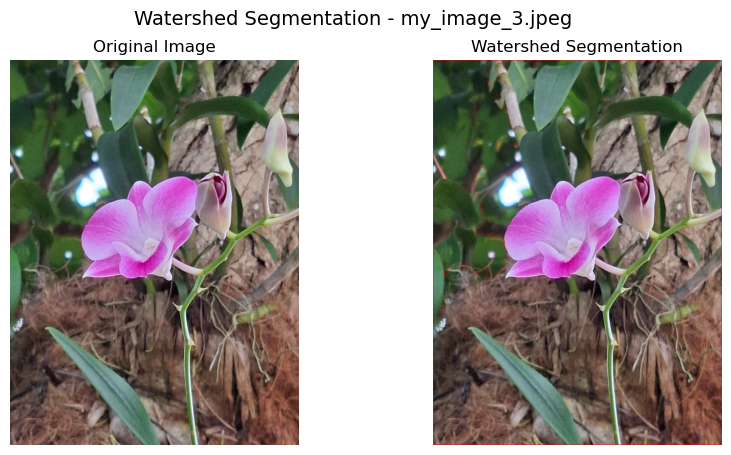

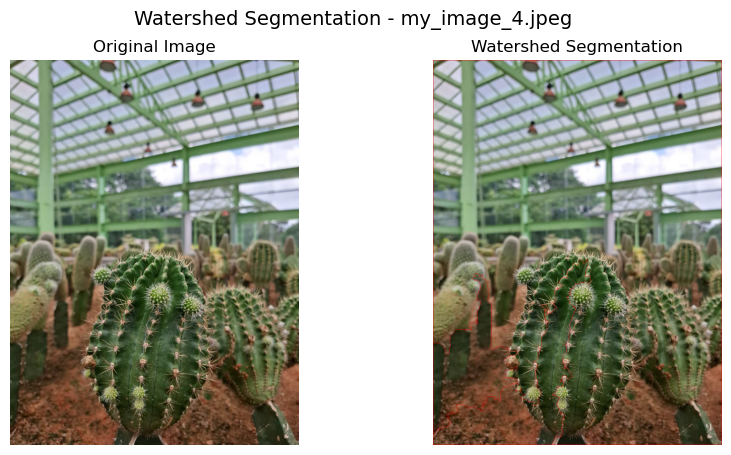

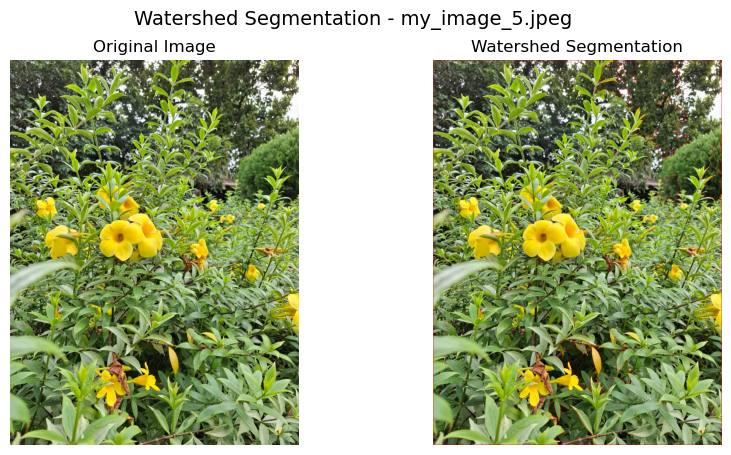

In [6]:
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    segmented_img, markers = watershed_segmentation(img_path)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(segmented_img)
    plt.title("Watershed Segmentation")
    plt.axis('off')

    plt.suptitle(f"Watershed Segmentation - {img_file}", fontsize=14)
    plt.show()


## Applications

1. **Medical Image Analysis**
2. **Manufacturing and Quality Control**
3. **Biological Research**
4. **Document Processing**
5. **Autonomous Systems**

---

## Advantages of Watershed Algorithm

1. **Excellent for touching/overlapping objects**: Main strength  
2. **Produces closed contours**: Complete object boundaries  
3. **Considers intensity gradients**: Uses image structure  
4. **Marker-based control**: Can guide segmentation with markers  
5. **Topology preservation**: Maintains spatial relationships  
6. **Works with any intensity pattern**: Not limited to specific textures

---

## Limitations and Challenges

1. **Over-segmentation prone**: May create too many regions without proper markers  
2. **Sensitive to noise**: Noise can create false minima  
3. **Requires preprocessing**: Needs good markers for best results  
4. **Computation intensive**: More complex than simple thresholding  
5. **Parameter tuning needed**: Distance threshold affects results  
6. **May miss weak boundaries**: Requires sufficient gradient

---

## Conclusion

The Watershed Algorithm is a sophisticated morphology-based segmentation technique that excels at separating touching or overlapping objects. By treating the image as a topographic surface and using marker-controlled flooding, it can accurately delineate object boundaries even in challenging scenarios. Understanding each step of the pipeline—from preprocessing to marker creation to watershed application—is crucial for achieving optimal segmentation results.

The algorithm's main strength lies in its ability to handle object separation, making it invaluable in fields like medical imaging, quality control, and biological research where precise object delineation is critical.